# Preamble

In [1]:


from plot_utils import visualize_tree, plot_results


In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

from plot_utils import visualize_tree, plot_results


In [3]:
titanic = pd.read_csv('Titanic.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Ready datasets

First clean up the data a little

In [4]:
#one-hot encode categorical features
male_column = pd.get_dummies(titanic["Sex"])[['male']]
embark_columns = pd.get_dummies(titanic["Embarked"])

#replace categorical features with new features
titanic = pd.concat([titanic, male_column, embark_columns], axis='columns').drop(['Sex', 'Embarked'], axis='columns')

#drop non-categorical text features
titanic = titanic.drop(['Name', 'Ticket', 'Cabin'], axis='columns')

#drop data with NaN values
titanic = titanic.dropna()

titanic.columns.to_numpy()

array(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch',
       'Fare', 'male', 'C', 'Q', 'S'], dtype=object)

Train and test sets

In [5]:
y = titanic['Survived']
X = titanic.drop('Survived', axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=504)


# Training a decision tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=504)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=504)

In [7]:
X_train

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
744,745,3,31.0,0,0,7.9250,True,False,False,True
848,849,2,28.0,0,1,33.0000,True,False,False,True
769,770,3,32.0,0,0,8.3625,True,False,False,True
319,320,1,40.0,1,1,134.5000,False,True,False,False
885,886,3,39.0,0,5,29.1250,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
25,26,3,38.0,1,5,31.3875,False,False,False,True
687,688,3,19.0,0,0,10.1708,True,False,False,True
853,854,1,16.0,0,1,39.4000,False,False,False,True
404,405,3,20.0,0,0,8.6625,False,False,False,True


<font size = 6>What could possibly go wrong?</font>

In [8]:
tree_clf.score(X_train, y_train)

1.0

Looks like overfitting. How about the test?

In [9]:
tree_clf.score(X_test, y_test)

0.7622377622377622

What happened?

In [10]:
visualize_tree(tree_clf, X_train.columns, ["Died", "Survived"]).view()

'C:\\Users\\krige\\AppData\\Local\\Temp\\tmpiqdz_20g.dot.pdf'

PassengerId should be irrelevant, but it allows the decision tree to turn into a full binary search tree. Let's drop it.

Also, Fare seems correlated to Pclass. Let's drop that, too.

In [11]:
X, X_train, X_test = X.drop(['PassengerId', 'Fare'], axis='columns'), X_train.drop(['PassengerId', 'Fare'], axis='columns'), X_test.drop(['PassengerId', 'Fare'], axis='columns')

tree_clf.fit(X_train, y_train)
tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)

(0.9474605954465849, 0.7832167832167832)

In [12]:
visualize_tree(tree_clf, X_train.columns, ["Died", "Survived"]).view()

'C:\\Users\\krige\\AppData\\Local\\Temp\\tmplyty75kn.dot.pdf'

Unconstrained decision trees tend to overfit, because they end up close to full binary search trees. This is also known as _pre-pruning_
We can constrain decision trees in several ways. Let's look at three important hyper-parameters.
* max_depth - puts a limit on how deep the tree can get. *Note*: The tree must be deep enough to accomodate all classes in the classification: 2^depth >= classes
* min_samples_split - forces a minimum of samples in a node before it gets split into subnodes
* max_features - forces the algorithm to only consider a certain number of features per node

### max_depth

In [13]:
tree_clf = DecisionTreeClassifier(random_state=504, max_depth=3)
tree_clf.fit(X_train, y_train)

tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)

(0.8073555166374781, 0.7832167832167832)

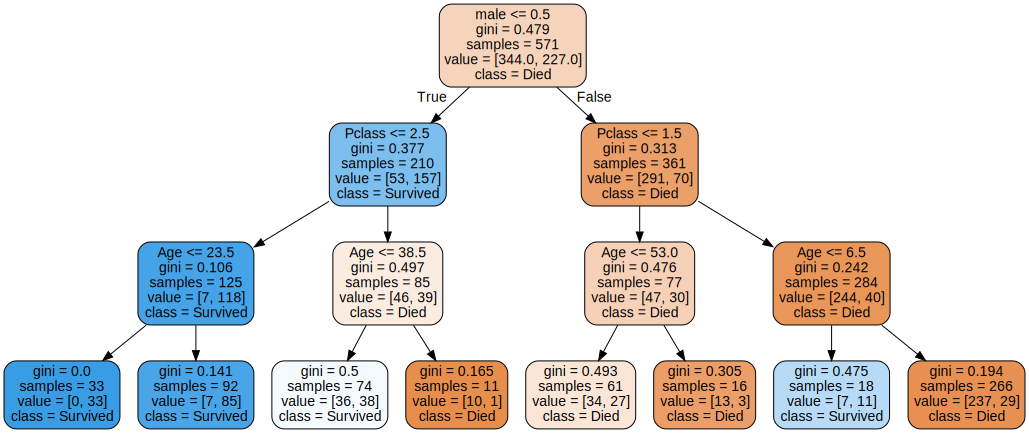

In [14]:
visualize_tree(tree_clf, X_train.columns, ["Died", "Survived"])

This decision tree is much less likely to overfit, because it is forced to generalized more. Of course, if the tree is too shallow, it will underfit.

Let's see how under- and overfitting depends on tree depth.

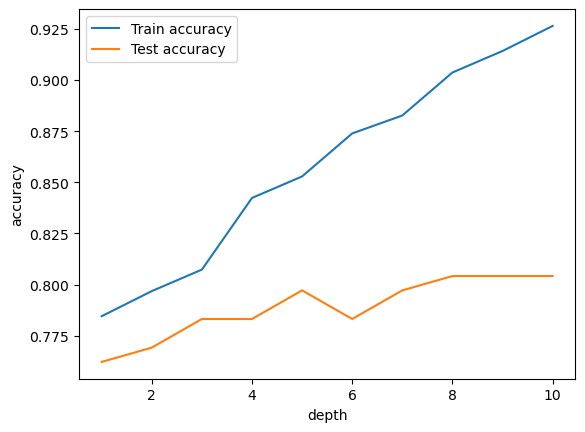

In [15]:
features = range(1, 11)

classifiers = [DecisionTreeClassifier(random_state=504, max_depth=d) for d in features]
for clf in classifiers: clf.fit(X_train, y_train)

train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]
plot_results(train_scores, test_scores, train_label="Train accuracy", test_label="Test accuracy", xlabel="depth", ylabel="accuracy")

This illustrates quite clearly how dangerous overfitting is for decision trees. Anyway, looks like a depth of 3 is the sweet spot.

### min_samples_split
Another way of constraining the tree is to be more reluctant to split. For instance, don't split further if there are no more than 10 samples in a leaf.

In [16]:
tree_clf = DecisionTreeClassifier(random_state=504, min_samples_split=10)
tree_clf.fit(X_train, y_train)

tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)

(0.882661996497373, 0.8041958041958042)

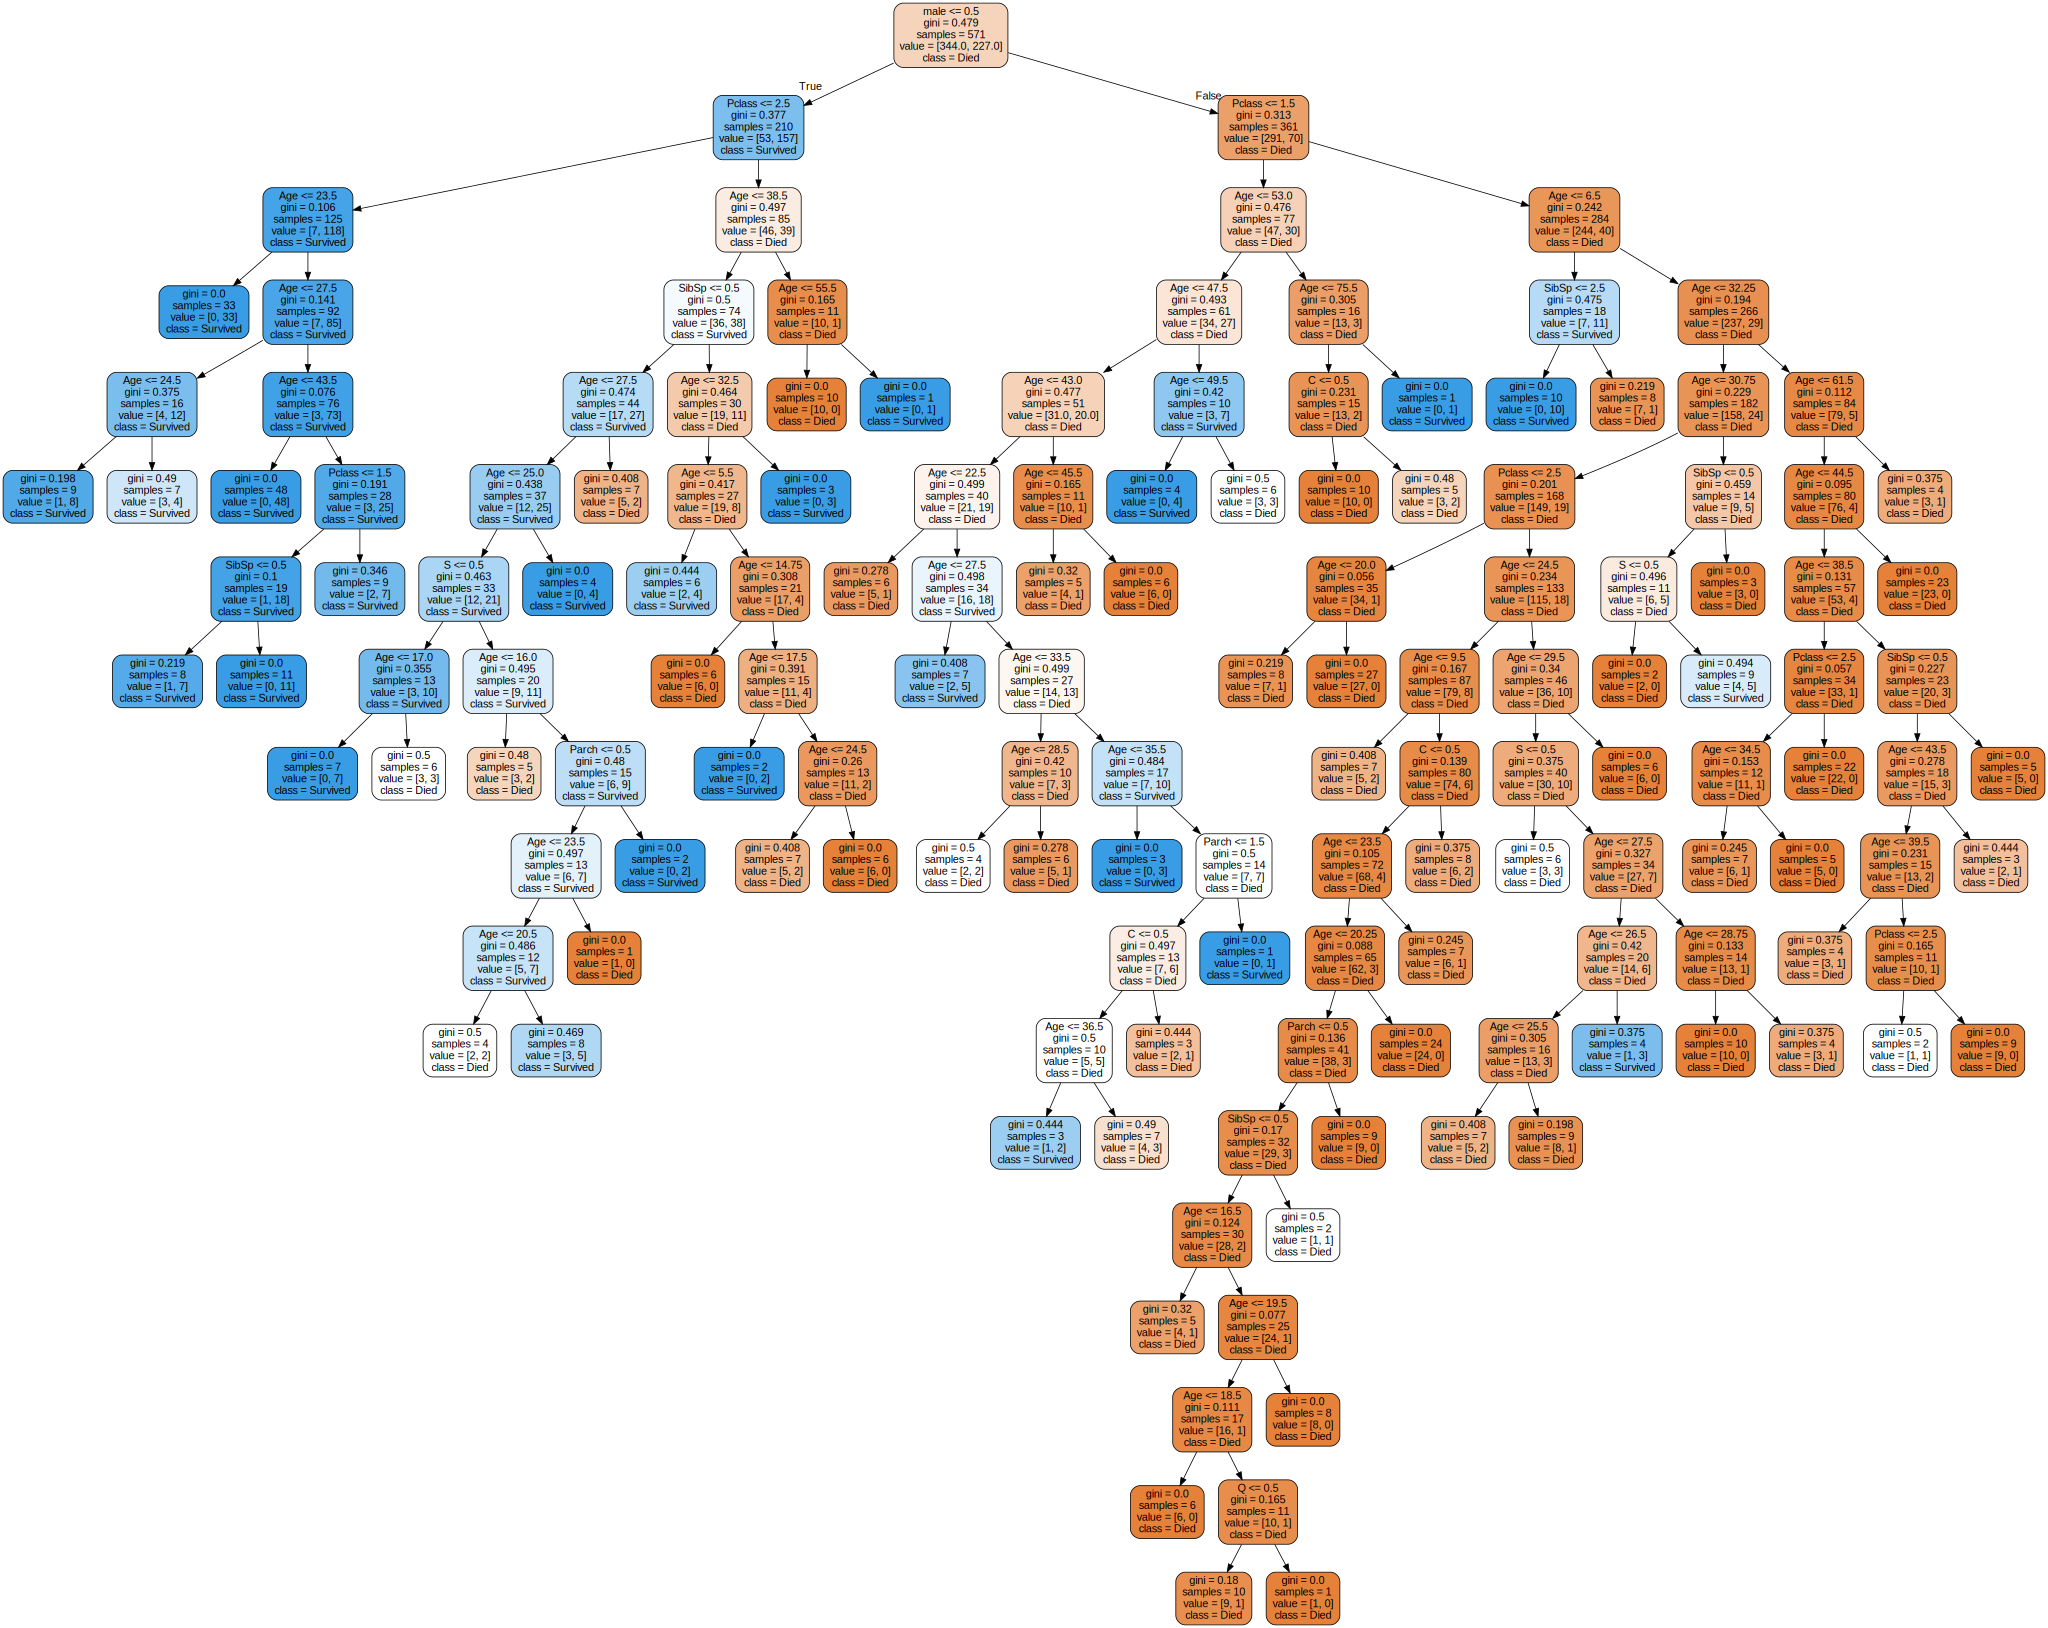

In [17]:
visualize_tree(tree_clf, X_train.columns, ["Died", "Survived"])

Let's see how the tree performs on different minimal node sizes.

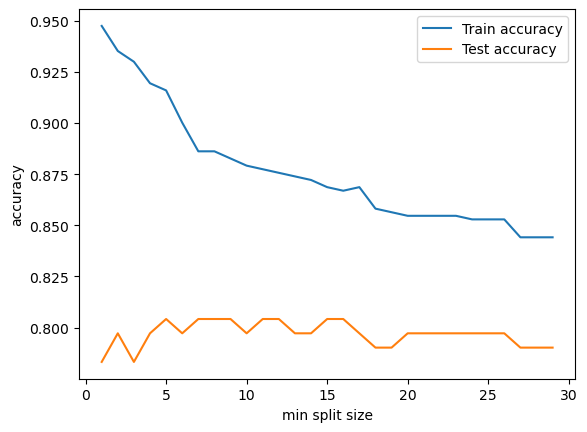

In [18]:
sizes = range(2, 31)

classifiers = [DecisionTreeClassifier(random_state=504, min_samples_split=s) for s in sizes]
for clf in classifiers: clf.fit(X_train, y_train)

train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]
plot_results(train_scores, test_scores, train_label="Train accuracy", test_label="Test accuracy", xlabel="min split size", ylabel="accuracy")

In [19]:
visualize_tree(tree_clf, X_train.columns, ["Died", "Survived"]).view()

'C:\\Users\\krige\\AppData\\Local\\Temp\\tmpwoihh63f.dot.pdf'

A shallow tree will usually have rather large samples in the leaves, so it doesn't make much sense to mix max_depth and min_samples_split.

An alternative way of telling the algorithm "only split if it's worth it" is to forbid splitting a node unless the improvement is big enough: min_impurity_decrease (see visualization)

### max_features

This is an odd duck. At each node the algorithm chooses a random subset of the features, which are used to evaluate the best split. It does *not* mean 'only split on the best n features', it means 'split on n *random* features'.

This makes for a faster algorithm if we have many features, but it also introduces random bias.

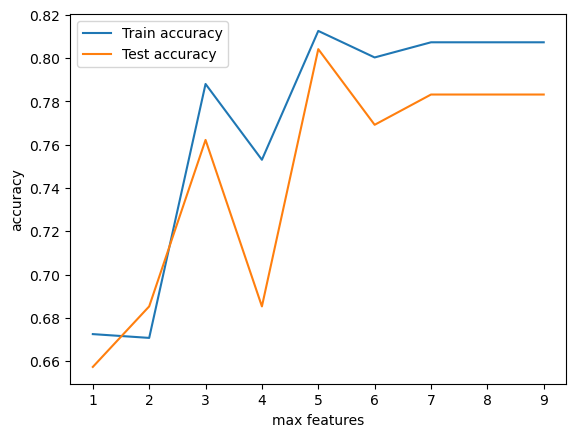

In [20]:
features = range(1, 10)

classifiers = [DecisionTreeClassifier(random_state=504, max_features=f, max_depth=3) for f in features]
for clf in classifiers: clf.fit(X_train, y_train)

train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]
plot_results(train_scores, test_scores, train_label="Train accuracy", test_label="Test accuracy", xlabel="max features", ylabel="accuracy")

Clearly, max_features should be 4. 

**What am I doing wrong here?**

In [21]:
tree_clf = DecisionTreeClassifier(random_state=504, max_features=4, max_depth=3)
tree_clf.fit(X_train, y_train)

tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)

(0.7530647985989493, 0.6853146853146853)

While this looks nice and not at all overfitting, we are tuning the hyperparameters on the test set. Now we need another set for validation.